In [135]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm
from sklearn import linear_model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import regex as re

In [136]:
df = pd.read_csv("houses_cleaned_baseline.csv")

In [137]:
df.head()

,Unnamed: 0,final_price,bathrooms,parking,description,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code,bedroom,den,sqft
0,0,855000,2,1,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76,2,1,850
1,1,885000,2,6,Fantastic Opportunity To Live Within The Histo...,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14,3,0,1380
2,2,550000,1,0,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104,1,0,550
3,3,665000,1,1,Rare Loft-Like Condo In Liberty Village W/ 18'...,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82,1,1,650
4,4,825513,2,1,Location! Location! Location. Your Cottage In ...,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"61 Twelfth St, Toronto , Ontario, Canada",43.597096,-79.509612,New Toronto,44101,18,2,0,924


### Data Exploration - Part 1

In [138]:
df_eda = df.copy(deep = True)

(25000.0, 200000.0)

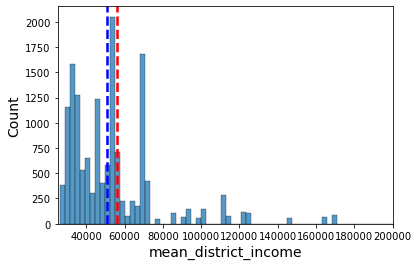

In [139]:
#Applicant income distribution
fig, ax = plt.subplots()

sns.histplot(df_eda['mean_district_income'],ax=ax)
ax.set_xlabel("mean_district_income", size=14)
ax.set_ylabel("Count", size=14)
ax.axvline(x=df.mean_district_income.median(),color='blue',ls='--',lw=2.5,label = 'median')
ax.axvline(x=df.mean_district_income.mean(),color='red',ls='--',lw=2.5, label = 'mean')
ax.set_xlim(25000,200000)

<AxesSubplot:xlabel='sqft', ylabel='final_price'>

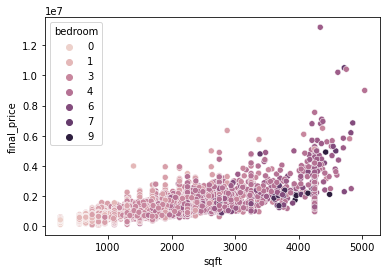

In [140]:
#Sqft vs Final Price wrt number of bedrooms
sns.scatterplot(x='sqft',y='final_price',hue='bedroom', data=df_eda)

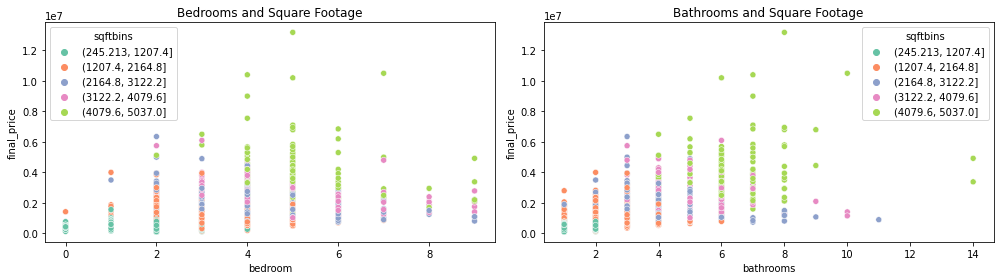

In [141]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

df_eda['sqftbins'] = pd.cut(df_eda["sqft"], bins=5)
sns.scatterplot(data=df_eda, x="bedroom", y="final_price", hue="sqftbins", palette='Set2', ax=ax1)
ax1.set_title('Bedrooms and Square Footage')

sns.scatterplot(data=df_eda, x="bathrooms", y="final_price", hue="sqftbins", palette='Set2', ax=ax2)
ax2.set_title('Bathrooms and Square Footage')

plt.tight_layout()
plt.show()

<Figure size 1152x216 with 0 Axes>

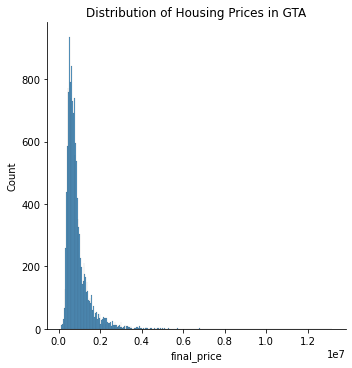

<Figure size 1152x216 with 0 Axes>

In [142]:
sns.displot(df_eda['final_price'])
plt.title('Distribution of Housing Prices in GTA')

plt.figure(5, figsize=[16,3])

C:\Users\bevli\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x720 with 0 Axes>

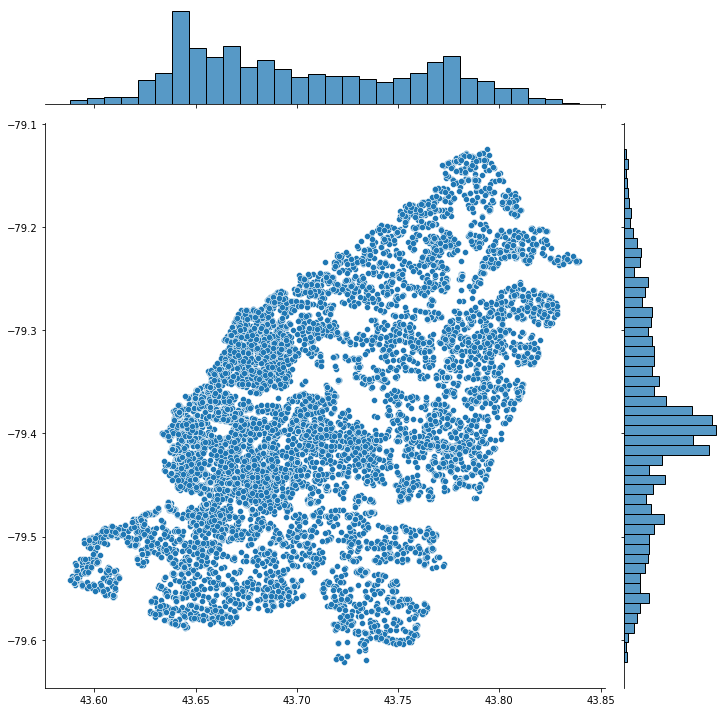

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [143]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df_eda.lat.values, y= df_eda.long.values, size = 10)
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()
sns.despine

In [144]:
city_districts = df_eda.city_district.unique().tolist()

### Feature Engineering

In [145]:
# Neighborhood crime rates obtained from data.torontopolice.on.ca
crime_df = pd.read_csv("Neighbourhood_Crime_Rates_2020.csv")

In [146]:
crime_df

,OBJECTID,Neighbourhood,Hood_ID,F2020_Population_Projection,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,Shootings_2020,Shooting_Rate2014,Shootings_Rate2015,Shootings_Rate2016,Shootings_Rate2017,Shootings_Rate2018,Shootings_Rate2019,Shootings_Rate2020,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,14083,16,25,34,25,28,35,...,0,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,1.161315e+06,5873.270507
1,2,York University Heights,27,30277,273,298,363,351,362,382,...,12,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,1.324666e+07,18504.777616
2,3,Lansing-Westgate,38,18146,42,81,67,84,68,70,...,1,0.000000,0.000000,5.980146,0.000000,5.737564,11.245430,5.510856,5.346186e+06,11112.109419
3,4,Yorkdale-Glen Park,31,17560,106,137,175,163,178,210,...,14,19.740740,19.752440,19.700550,44.312210,61.042610,100.170900,79.726650,6.038326e+06,10079.426837
4,5,Stonegate-Queensway,16,27410,91,74,78,98,86,83,...,0,11.702290,7.788465,0.000000,3.821754,3.759257,3.702744,0.000000,7.946202e+06,11853.189803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136,Pleasant View,46,16856,34,45,56,54,46,51,...,2,0.000000,18.367720,6.139866,6.087539,6.035367,0.000000,11.865210,2.967493e+06,7944.829782
136,137,Wychwood,94,16037,54,72,80,54,74,69,...,2,0.000000,6.798097,0.000000,0.000000,6.481721,6.357279,12.471160,1.682111e+06,5435.022062
137,138,Leaside-Bennington,56,18627,41,30,38,38,36,32,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.784766e+06,14836.618542
138,139,Briar Hill-Belgravia,108,15448,79,91,80,75,91,81,...,1,6.781040,0.000000,6.792094,33.559300,13.254690,13.093290,6.473330,1.830325e+06,6289.707250


In [147]:
#dropping data from 2019 to 2020 as dataset has houses from 2018

crime_df = crime_df[crime_df.columns.drop(list(crime_df.filter(regex='2019')))]
crime_df = crime_df[crime_df.columns.drop(list(crime_df.filter(regex='2020')))]

In [148]:
#Finding averages from 2014 to 2018 for each crime metric and adding to dataframe
crime_df['Assault_Rate'] = crime_df[['Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018']].mean(axis = 1)

crime_df['Auto_Theft_Rate'] = crime_df[[ 'AutoTheft_Rate2014', 'AutoTheft_Rate2015', 'AutoTheft_Rate2016',
       'AutoTheft_Rate2017', 'AutoTheft_Rate2018']].mean(axis = 1)

crime_df['Break_andEnter_Rate'] = crime_df[['BreakAndEnter_Rate2014',
       'BreakAndEnter_Rate2015', 'BreakAndEnter_Rate2016',
       'BreakAndEnter_Rate2017', 'BreakAndEnter_Rate2018']].mean(axis = 1)

crime_df['Robbery_Rate'] = crime_df[[ 'Robbery_Rate2014', 'RobberyRate_2015', 'Robbery_Rate2016',
       'Robbery_Rate2017', 'Robbery_Rate2018']].mean(axis = 1)

crime_df['Shootings_Rate'] = crime_df[['Shooting_Rate2014', 'Shootings_Rate2015', 'Shootings_Rate2016',
       'Shootings_Rate2017', 'Shootings_Rate2018']].mean(axis = 1)

In [149]:
crime_df.drop(columns = ['Assault_2014', 'Assault_2015',
       'Assault_2016', 'Assault_2017', 'Assault_2018', 'Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018', 'AutoTheft_2014', 'AutoTheft_2015',
       'AutoTheft_2016', 'AutoTheft_2017', 'AutoTheft_2018',
       'AutoTheft_Rate2014', 'AutoTheft_Rate2015', 'AutoTheft_Rate2016',
       'AutoTheft_Rate2017', 'AutoTheft_Rate2018', 'BreakAndEnter_2014',
       'BreakAndEnter_2015', 'BreakAndEnter_2016', 'BreakAndEnter_2017',
       'BreakAndEnter_2018', 'BreakAndEnter_Rate2014',
       'BreakAndEnter_Rate2015', 'BreakAndEnter_Rate2016',
       'BreakAndEnter_Rate2017', 'BreakAndEnter_Rate2018', 'Robbery_2014',
       'Robbery_2015', 'Robbery_2016', 'Robbery_2017', 'Robbery_2018',
       'Robbery_Rate2014', 'RobberyRate_2015', 'Robbery_Rate2016',
       'Robbery_Rate2017', 'Robbery_Rate2018', 'TheftOver_2014',
       'TheftOver_2015', 'TheftOver_2016', 'TheftOver_2017', 'TheftOver_2018',
       'TheftOver_Rate2014', 'TheftOver_Rate2015', 'TheftOver_Rate2016',
       'TheftOver_Rate2017', 'TheftOver_Rate2018', 'Homicide_2014',
       'Homicide_2015', 'Homicide_2016', 'Homicide_2017', 'Homicide_2018',
       'Homicide_Rate2014', 'Homicide_Rate2015', 'Homicide_Rate2016',
       'Homicide_Rate2017', 'Homicide_Rate2018', 'Shootings_2014',
       'Shootings_2015', 'Shootings_2016', 'Shootings_2017', 'Shootings_2018',
       'Shooting_Rate2014', 'Shootings_Rate2015', 'Shootings_Rate2016',
       'Shootings_Rate2017', 'Shootings_Rate2018'],inplace = True, axis = 1)

In [156]:
#check if both dataframes have the exact same neighbourhoods

for i in range(140):
    if (sorted(city_districts)[i] == sorted(crime_df.Neighbourhood)[i]):
        pass
    else:
        print (sorted(city_districts)[i]," - ", sorted(crime_df.Neighbourhood)[i])


Cabbagetown-South St. James Town  -  Cabbagetown-South St.James Town
North St. James Town  -  North St.James Town
Weston-Pelham Park  -  Weston-Pellam Park


In [155]:
df["city_district"].replace({"Cabbagetown-South St. James Town": "Cabbagetown-South St.James Town", "North St. James Town": "North St.James Town", "Weston-Pelham Park": "Weston-Pellam Park"}, inplace=True)

In [157]:
#merging crime DataFrame to EDA DataFrame and original DataFrame
df_eda = pd.merge(df_eda, crime_df, left_on=['city_district'],right_on=['Neighbourhood'], how = 'inner')
df = pd.merge(df, crime_df, left_on=['city_district'],right_on=['Neighbourhood'], how = 'inner')

In [158]:
df

,Unnamed: 0,final_price,bathrooms,parking,description,type,full_link,full_address,lat,long,...,OBJECTID,Neighbourhood,Hood_ID,Shape__Area,Shape__Length,Assault_Rate,Auto_Theft_Rate,Break_andEnter_Rate,Robbery_Rate,Shootings_Rate
0,0,855000,2,1,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,...,94,Bay Street Corridor,76,1.809355e+06,6933.183322,2511.64080,100.953830,532.97306,371.578160,12.331211
1,85,785000,1,1,Five Condos - Stunning Bright Corner Unit In A...,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"5 St Joseph St, Toronto , Ontario, Canada",43.665753,-79.385579,...,94,Bay Street Corridor,76,1.809355e+06,6933.183322,2511.64080,100.953830,532.97306,371.578160,12.331211
2,154,718000,2,0,"Spacious 2 Bedrooms, 2 Full Baths, Over 1000 S...",Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"633 Bay St, Toronto , Ontario, Canada",43.656674,-79.383443,...,94,Bay Street Corridor,76,1.809355e+06,6933.183322,2511.64080,100.953830,532.97306,371.578160,12.331211
3,161,968000,2,1,Beautiful Burano On Bay Is A Diamond In The Sk...,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"832 Bay St, Toronto , Ontario, Canada",43.661927,-79.386511,...,94,Bay Street Corridor,76,1.809355e+06,6933.183322,2511.64080,100.953830,532.97306,371.578160,12.331211
4,216,650000,2,1,*Smart & Functional One Bdrm + Den + Extra Bat...,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"111 Elizabeth St, Toronto , Ontario, Canada",43.655055,-79.384721,...,94,Bay Street Corridor,76,1.809355e+06,6933.183322,2511.64080,100.953830,532.97306,371.578160,12.331211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15229,11499,1430000,5,2,Custom Built! Brand New Never Been Lived!Cover...,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"33 Cosens St, Toronto , Ontario, Canada",43.796526,-79.173685,...,72,Highland Creek,134,5.248058e+06,9914.922698,447.88006,117.118962,241.45518,127.159984,9.079792
15230,12791,900000,3,4,"Immaculate 4 Bed, 3 Bath Raised Bungalow With ...",Detached,https://www.zoocasa.com/toronto-on-real-estate...,"57 Watson St, Toronto , Ontario, Canada",43.786423,-79.173985,...,72,Highland Creek,134,5.248058e+06,9914.922698,447.88006,117.118962,241.45518,127.159984,9.079792
15231,14732,805000,4,2,"4 Bedroom, 4 Washroom Home In Prestigious High...",Detached,https://www.zoocasa.com/toronto-on-real-estate...,"44 Fishery Rd, Toronto , Ontario, Canada",43.791859,-79.175068,...,72,Highland Creek,134,5.248058e+06,9914.922698,447.88006,117.118962,241.45518,127.159984,9.079792
15232,14950,740000,4,4,You Will Love The Location Of This All Brick F...,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"76 Muirbank Blvd, Toronto , Ontario, Canada",43.795167,-79.158194,...,72,Highland Creek,134,5.248058e+06,9914.922698,447.88006,117.118962,241.45518,127.159984,9.079792


In [159]:
df.describe()

,Unnamed: 0,final_price,bathrooms,parking,lat,long,mean_district_income,district_code,bedroom,den,sqft,OBJECTID,Hood_ID,Shape__Area,Shape__Length,Assault_Rate,Auto_Theft_Rate,Break_andEnter_Rate,Robbery_Rate,Shootings_Rate
count,15234.000000,1.523400e+04,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,1.523400e+04,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000,15234.000000
mean,7616.500000,8.827136e+05,2.122227,1.559144,43.702658,-79.394666,56065.642576,71.300643,2.335500,0.539583,1315.527767,71.731325,71.300643,6.217339e+06,12220.953915,710.060529,119.224446,258.241373,130.031495,10.686355
std,4397.821336,6.189336e+05,1.128122,1.345642,0.056806,0.095425,32547.705435,38.673608,1.136062,0.667572,751.379691,40.413891,38.673608,5.669389e+06,6676.231824,469.686694,107.575272,111.497223,100.134485,10.543200
min,0.000000,1.030000e+05,1.000000,0.000000,43.588176,-79.621693,25989.000000,1.000000,0.000000,0.000000,250.000000,1.000000,1.000000,4.241968e+05,2574.408552,123.431522,25.391624,91.711428,10.528852,0.000000
25%,3808.250000,5.350000e+05,1.000000,1.000000,43.652058,-79.454611,34904.000000,39.000000,1.000000,0.000000,750.000000,40.000000,39.000000,2.480023e+06,7606.039068,371.637720,71.791840,172.646380,65.075220,2.805392
50%,7616.500000,7.150000e+05,2.000000,1.000000,43.690963,-79.395589,50580.000000,76.000000,2.000000,0.000000,1133.500000,71.000000,76.000000,4.784766e+06,10750.468290,583.182560,93.681336,226.376580,108.759882,8.282310
75%,11424.750000,9.890000e+05,3.000000,2.000000,43.755905,-79.335266,67757.000000,101.000000,3.000000,1.000000,1666.000000,103.000000,101.000000,7.464327e+06,15361.246270,841.358840,129.144500,327.742400,160.364920,15.243956
max,15233.000000,1.318000e+07,14.000000,11.000000,43.839372,-79.124094,308010.000000,140.000000,9.000000,6.000000,5037.000000,140.000000,140.000000,3.753449e+07,43080.724785,2511.640800,975.046860,799.605420,587.762480,58.879640


In [164]:
df.to_csv('houses_cleaned_baseline_crimedata.csv')